In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import cufflinks as cf
#cf.go_offline()


# Goal

Given an unknown dataset. Predict the response **y** using a feature set comprised of the variables **x0 : x49**.

Identify the optimized model and feature set that maximizes accuracy and minimizes cost given the following constraints:

Each False Positive increases cost by `$`10  <br>
Each False Negative inreases cost by `$`500 <br>
True Predictions will not increase cost. <br>


In [291]:
df = pd.read_csv ('./final_project.csv')

# Data

The data set consists 160,000 observations that record the response variable **y** and up to 50 potential predictive variables **x0 : x49**. While it is unknown what the variables represent, it is known that the response variable is binary and in each of the recorded observations it has the value of either 0 or 1. Accross the data set there are 1608 missing values. Therefore, applying listwise deletion to address the missing data would result in a loss of up to 1% of the observations. 

A preliminary review of the dataset indicates that within the predictive variable set, there are a total of 46 numerical variables and 4 categorical variables. The four categorical variables are (**x24, x29, x30, x32**). 

In [292]:
print("Records and Fields: ", df.shape)
print("Total Missing Values: ", df.isnull().sum().sum())

Records and Fields:  (160000, 51)
Total Missing Values:  1608


A closer review of the categorical variables indicates that variable **x32** is likely a numerical variable that represents a percentage. Subsequently, variable **x32** was then coded as a float type and missing values were checked to ensure that no missing values were inadvertantly imputed or dropped inadvertantly.

In [293]:
cat = ["x24","x29","x30","x32"]
print(df[cat].describe(), "\n")

df["x32"] = df["x32"].str.rstrip('%')
df["x32"] = df["x32"].apply(pd.to_numeric, errors='coerce').astype('float64')

print("Total Missing Values: ", df.isnull().sum().sum()) 

           x24     x29        x30     x32
count   159972  159970     159970  159969
unique       3      12          5      12
top       asia    July  wednesday   0.01%
freq    138965   45569     101535   40767 

Total Missing Values:  1608


In [294]:
cat = ["x24","x29","x30"]
df[cat].head()

,x24,x29,x30
0,euorpe,July,tuesday
1,asia,Aug,wednesday
2,asia,July,wednesday
3,asia,July,wednesday
4,asia,July,tuesday


A review of the categorical variables indicates that variable **x24** might represent a continent or region and that within the variable there are 3 unique values. Variable **x29** seems to represent a calendar month and contains 12 unique values. Lastly, variable **x30** seem to represent a weekday and contains 5 unique values. Missing values whithin each field range from 28 to 30. 

In [295]:
print("Total Missing Values:") 
print(df[cat].isnull().sum())

Total Missing Values:
x24    28
x29    30
x30    30
dtype: int64


At most, only 88 observations or .05% of the total observations would be lost through listwise deletion of missing categorical values and according to our own studies along with those of researchers like that of Paul D. Allison of the University of Pennsylvania, listwise deletion of categorical variables can achieve results similar to more complicated methods like that of the Markov Chain Monte Carlo (MCMC) algorithm used in popular imputation processes.  Therefore we decided to delete the observations in which a categorical variable had missing data rather than risk introducing bias through imputation. This decision was heavily influenced by the fact that we did not know if the data was missing at random or if there was an underlying correlation between a value being missing and another variable.  

In [296]:
df = df.dropna(subset=['x24', 'x29','x30'])
print("Total Missing Values: ", df.isnull().sum().sum()) 

Total Missing Values:  1520


Because little was known about the numerical variables or their potential interactions and associations, no additional preprocessing was done before moving on to exploratory data analysis.  

# EDA

Although we do not know what the response variable y represents, we will refer to values of 1 as a positive response and values of 0 as a negative response for the sake of simplyfying the explanation of our findings and methodology in the exploratory data analysis and going forward.

#### Response Variable

Text(0, 0.5, 'Count')

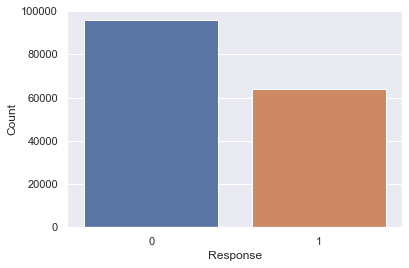

In [297]:
ax = sns.countplot(x = 'y', data = df)
ax.set_xlabel("Response")
ax.set_ylabel("Count")

A review of the response variable indicates that there are are 40.1% positive responses compared to 59.9% negative responses. This means that we might have to consider balancing the classes as we move forward, though initially the class imblance does not seem extreme. 

In [298]:
p1 = len(df[df["y"]==1])/len(df["y"])*100
p0 = len(df[df["y"]==0])/len(df["y"])*100
print( "y = 0 : ",  len(df[df["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df[df["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df.isnull().sum().sum())

y = 0 :  95753 , 59.879 %
y = 1 :  64159 , 40.121 %
Total Missing Values:  1520


In [299]:
df1 = df.dropna()

The effect of listwise deletion on the response variable balance was examined, but since dropping missing values did not affect the ratio of positive to negative responses we decided that at this point we would not drop records with missing numeric values and consider imputation as a possible option for those variables.    

In [300]:
p1 = len(df1[df1["y"]==1])/len(df1["y"])*100
p0 = len(df1[df1["y"]==0])/len(df1["y"])*100
print( "y = 0 : ",  len(df1[df1["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df1[df1["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df1.isnull().sum().sum()) 

y = 0 :  94846 , 59.881 %
y = 1 :  63546 , 40.119 %
Total Missing Values:  0


#### Categorical Variables

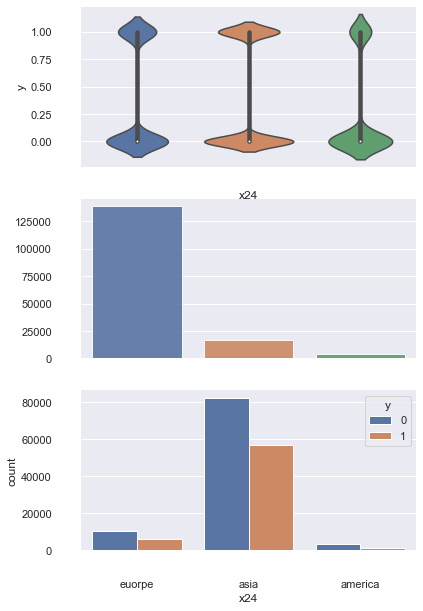

In [301]:
count = df['x24'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x='x24', y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x24', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

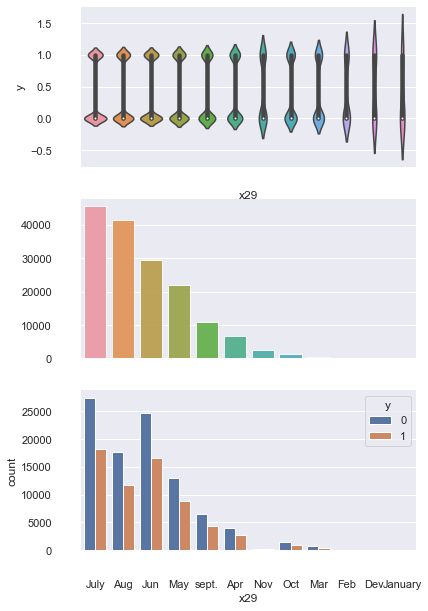

In [302]:
count = df['x29'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x29", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x29', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

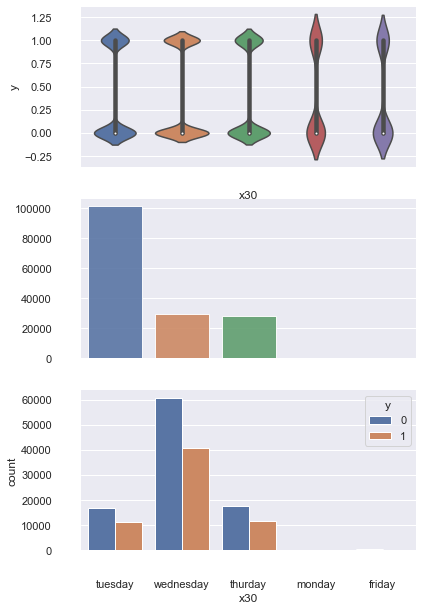

In [303]:
count = df['x30'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x30", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x30', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

In [205]:
print(count)

wednesday    101492
thurday       29421
tuesday       27947
friday          564
monday          488
Name: x30, dtype: int64


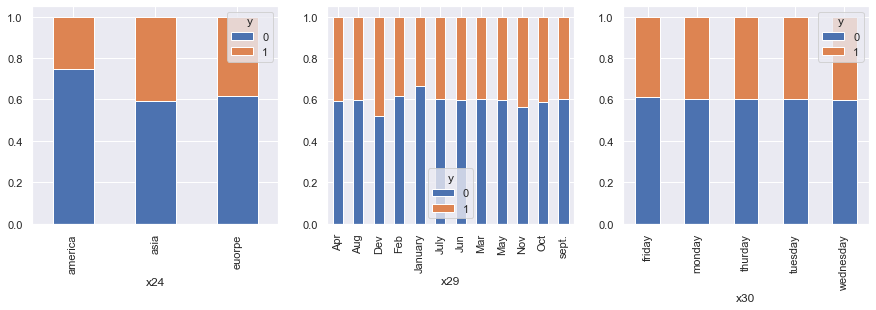

In [314]:
f, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)
table1=pd.crosstab(df.x24,df.y)
table2=pd.crosstab(df.x29,df.y)
table3=pd.crosstab(df.x30,df.y)
table1.div(table1.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0])
table2.div(table2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1])
table3.div(table3.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2])

#### Continous Variables

In [255]:
df_num = df.drop(['x24', 'x29', 'x30'], axis=1)

In [361]:
dfc1 = df_num.iloc[:, np.r_[0:13, 47]]
dfc2 = df_num.iloc[:, np.r_[14:24, 47]]
dfc3 = df_num.iloc[:, np.r_[25:35, 47]]
dfc4 = df_num.iloc[:, np.r_[35:46, 47]]

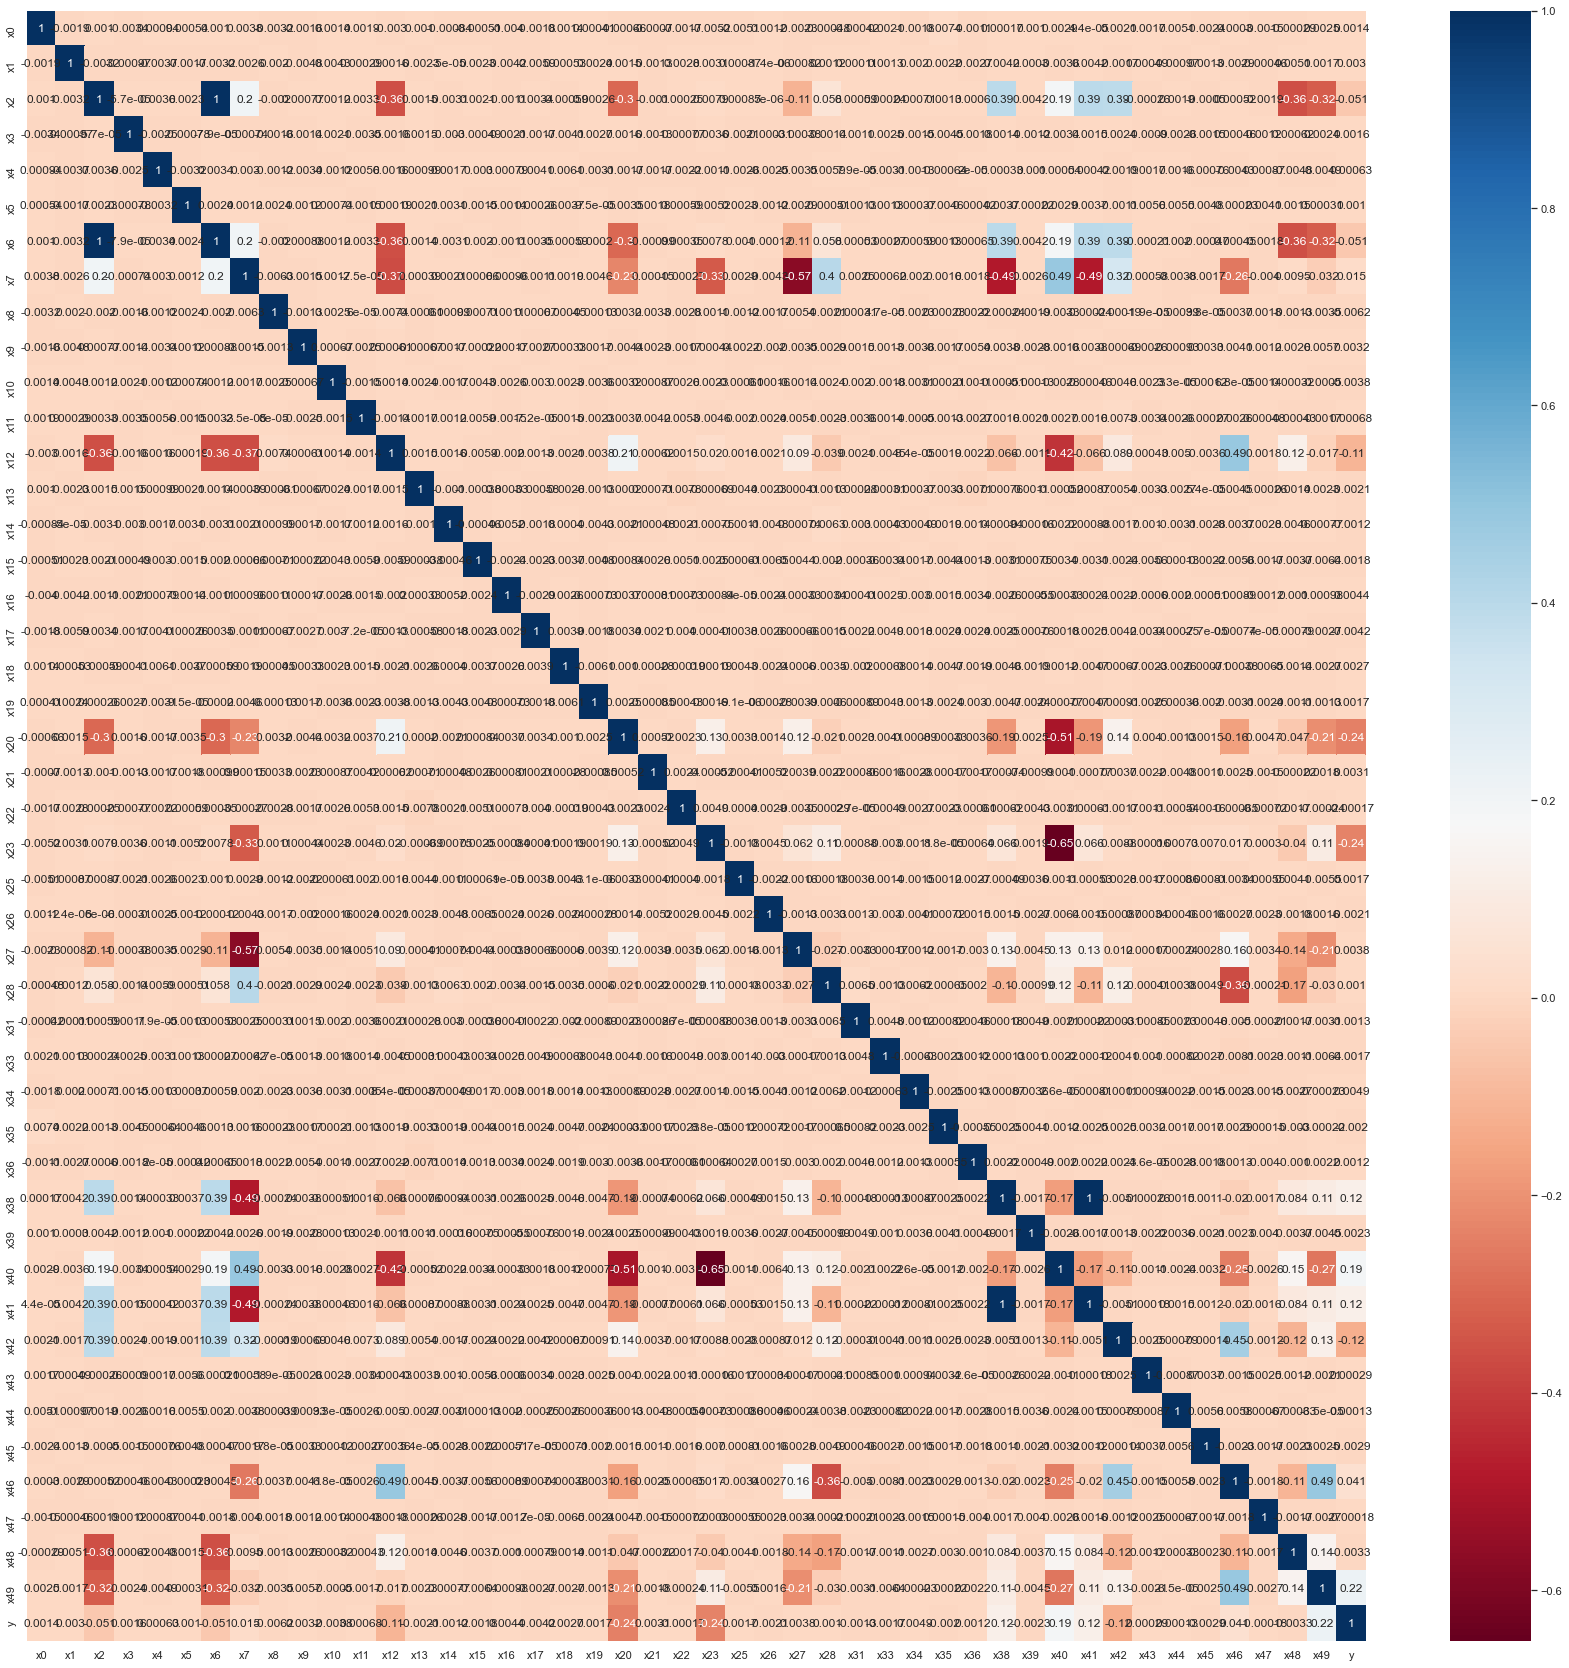

In [360]:
ax, fig = plt.subplots(figsize = (30,30))
sns.heatmap(df_num.corr(), annot=True, cmap = 'RdBu') 

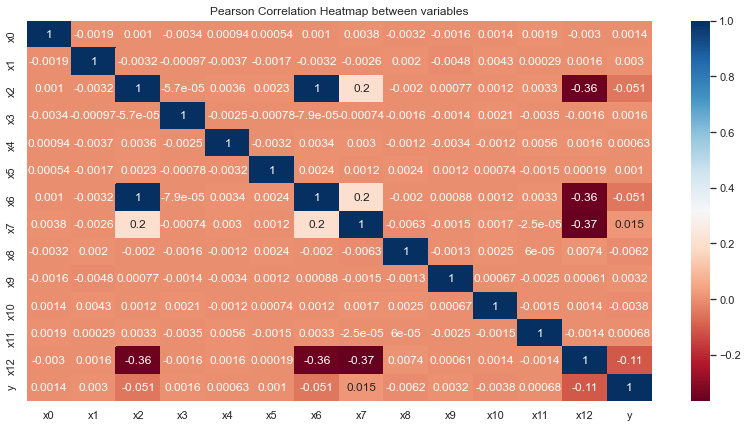

In [358]:
ax, fig = plt.subplots(figsize = (14,7))
sns.set(font_scale=1)
sns.heatmap(dfc1.corr(), annot=True, cmap = 'RdBu') 
plt.title("Pearson Correlation Heatmap between variables")
plt.show()

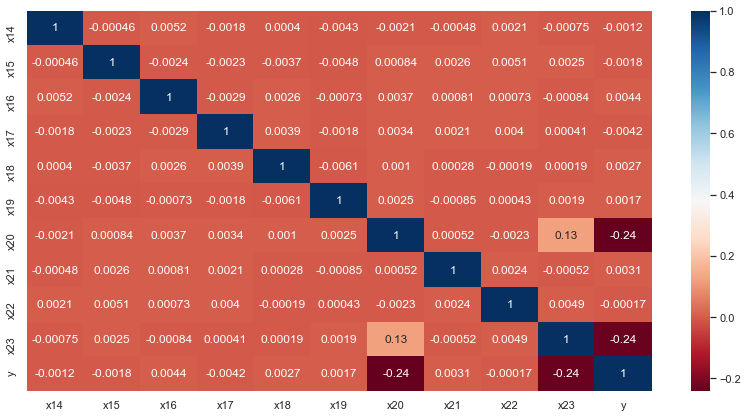

In [353]:
ax, fig = plt.subplots(figsize = (14,7))
sns.heatmap(dfc2.corr(), annot=True, cmap = 'RdBu') 

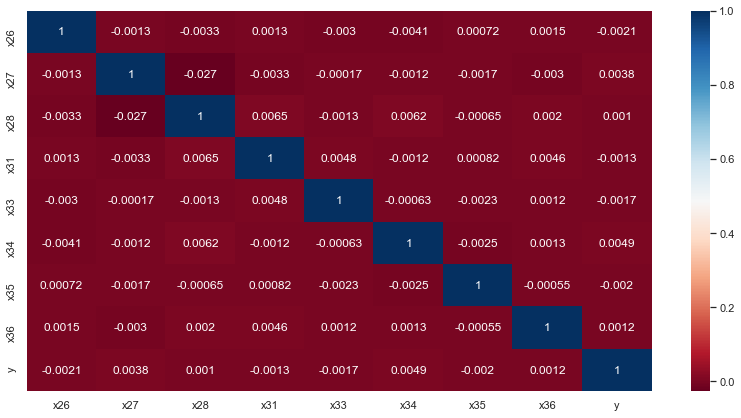

In [354]:
ax, fig = plt.subplots(figsize = (14,7))
sns.heatmap(dfc3.corr(), annot=True, cmap = 'RdBu')

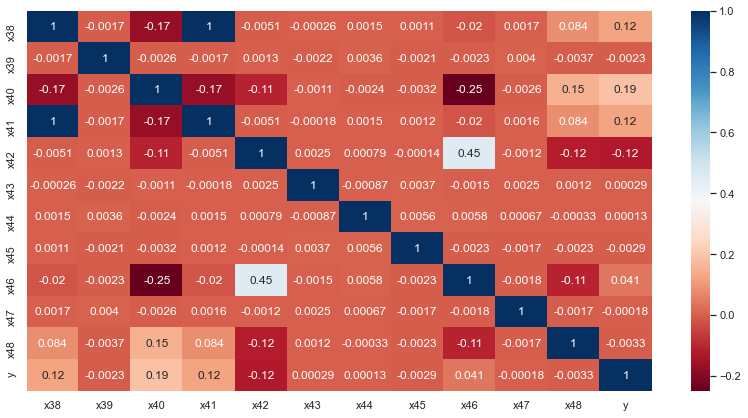

In [362]:
ax, fig = plt.subplots(figsize = (14,7))
sns.heatmap(dfc4.corr(), annot=True, cmap = 'RdBu')

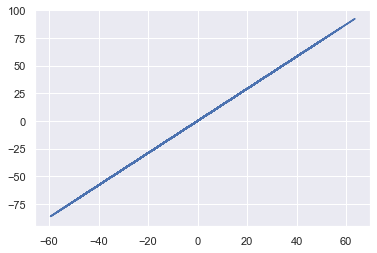

In [365]:
plt.plot(df['x2'], df['x6'])

In [351]:
dfc1[['x2','x6']].describe()

,x2,x6
count,159874.000000,159886.000000
mean,-1.148940,-1.668917
std,13.274082,19.299539
min,-59.394048,-86.354483
25%,-10.165405,-14.778726
50%,-1.340161,-1.947181
75%,7.874129,11.449278
max,63.545653,92.390605


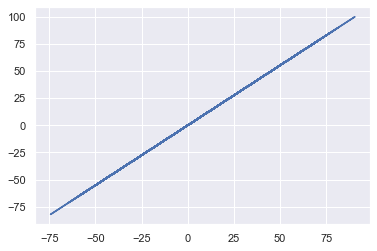

In [366]:
plt.plot(df['x38'], df['x41'])

In [368]:
dfc4[['x38','x41']].describe()

,x38,x41
count,159881.000000,159872.000000
mean,6.060389,6.702469
std,16.892290,18.680956
min,-74.297559,-82.167224
25%,-5.249882,-5.804080
50%,6.186954,6.842820
75%,17.421053,19.266854
max,90.467981,100.050432


In [322]:
df_num

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-0.487024,-4.270269,0.417395,-1.992423,1.757552,-1.167819,0.606860,41.084463,-1.923188,-2.374213,...,-9.390451,8.096802,-0.875131,-1.413787,-0.363968,15.339392,4.364205,-3.831489,28.389858,1
159996,0.825477,4.804368,22.161535,11.371303,1.715901,6.990759,32.221207,-12.278038,-3.861086,6.715126,...,12.803189,0.841446,-0.682177,-5.047677,-0.017898,0.780130,6.387266,-1.374742,-1.623952,0
159997,-0.802489,5.362696,7.243419,-7.496074,2.295250,-2.756067,10.531388,42.515821,1.420984,6.788916,...,-0.346570,-0.144098,0.738298,7.241041,0.215347,-12.155249,3.265263,1.230963,3.335471,1
159998,0.339237,7.609895,5.368414,-2.825481,4.046102,15.322603,7.805271,-10.233054,2.609986,4.251127,...,-0.307656,-0.601145,-3.443112,0.549931,0.206728,5.081980,1.701462,-0.279619,-1.986424,0


In [257]:
df1 = df_num.iloc[:,0:9]
df2 = df_num.iloc[:,10:19]
df3 = df_num.iloc[:,20:29]
df4 = df_num.iloc[:,30:40]
df5 = df_num.iloc[:,41:47]

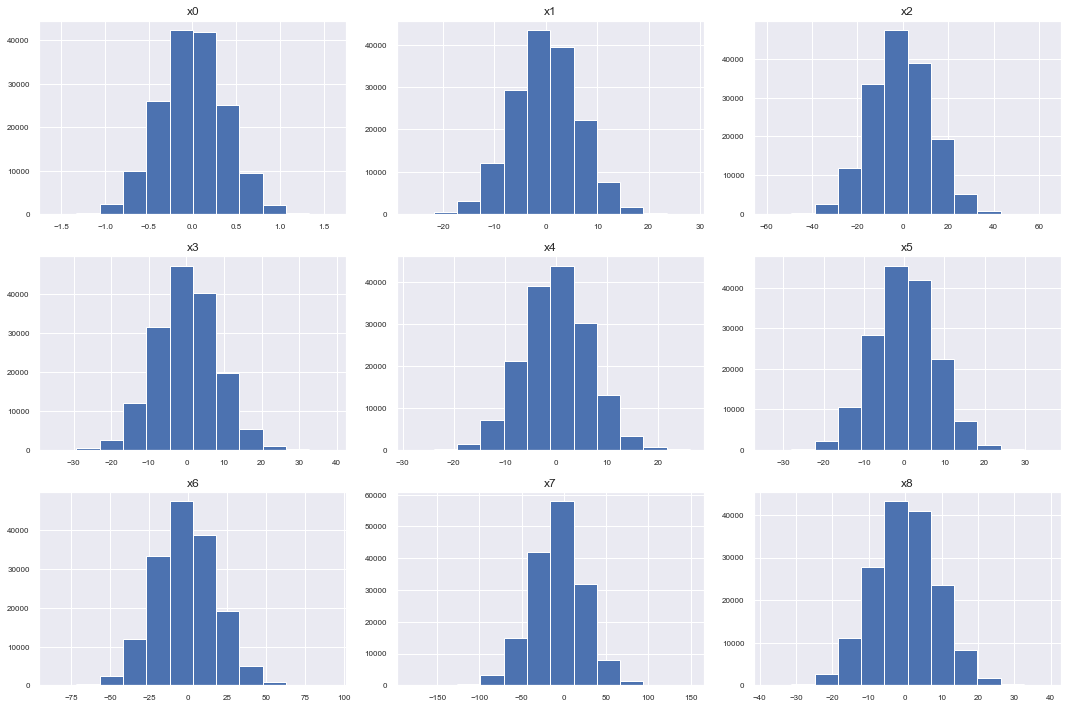

In [269]:
df1.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

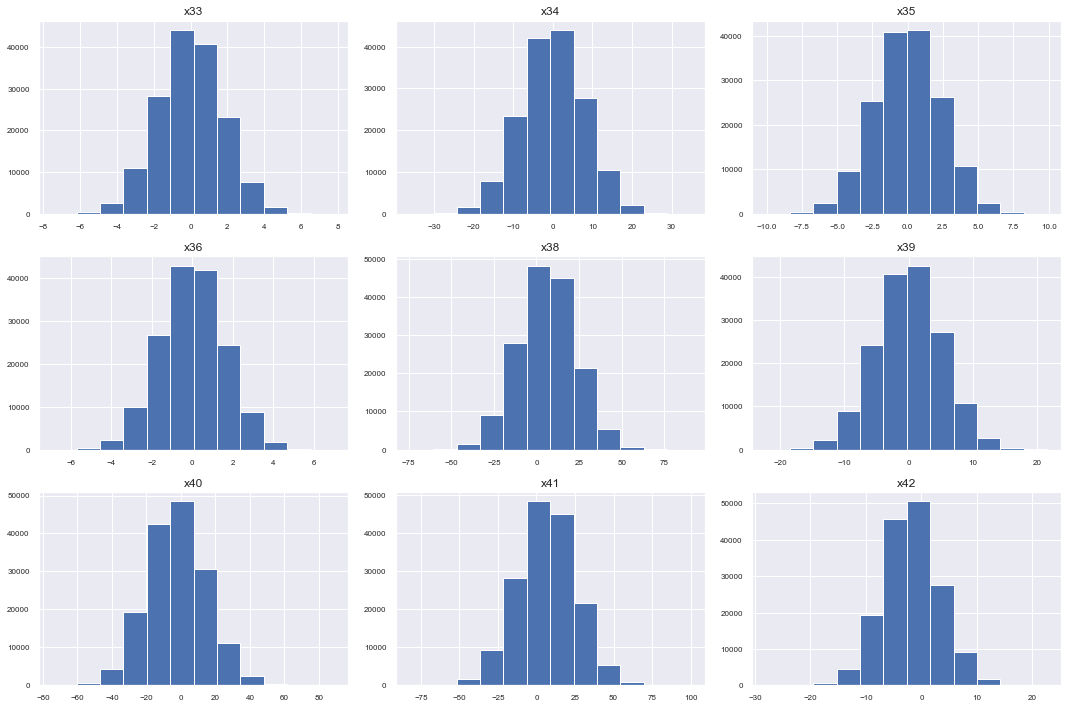

In [281]:
df4.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

In [253]:
df.corr()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
x0,1.000000,-0.001894,0.001008,-0.003418,0.000938,0.000539,0.001044,0.003795,-0.003181,-0.001624,...,0.000044,0.002126,0.001745,0.005116,-0.002366,0.000302,-0.001504,-0.000288,0.002502,0.001404
x1,-0.001894,1.000000,-0.003215,-0.000972,-0.003718,-0.001745,-0.003248,-0.002650,0.001952,-0.004797,...,0.004199,-0.001695,0.000485,-0.000970,0.001333,-0.002882,-0.000460,0.005067,0.001722,0.003049
x2,0.001008,-0.003215,1.000000,-0.000057,0.003569,0.002335,1.000000,0.203472,-0.001977,0.000772,...,0.394813,0.390239,-0.000263,0.001915,-0.000505,0.000522,-0.001938,-0.356314,-0.324882,-0.050654
x3,-0.003418,-0.000972,-0.000057,1.000000,-0.002475,-0.000781,-0.000079,-0.000739,-0.001580,-0.001441,...,0.001477,0.002363,-0.000903,-0.002632,-0.001486,0.000459,0.001250,0.000625,0.002360,0.001630
x4,0.000938,-0.003718,0.003569,-0.002475,1.000000,-0.003217,0.003418,0.002980,-0.001168,-0.003418,...,0.000419,-0.001940,0.001662,0.001621,-0.000762,-0.004279,0.000871,-0.004762,-0.004924,0.000634
x5,0.000539,-0.001745,0.002335,-0.000781,-0.003217,1.000000,0.002444,0.001154,0.002372,0.001158,...,0.003714,-0.001119,0.005606,0.005504,0.004834,-0.000230,0.004102,0.001506,0.000305,0.000999
x6,0.001044,-0.003248,1.000000,-0.000079,0.003418,0.002444,1.000000,0.203516,-0.002012,0.000879,...,0.394831,0.390191,-0.000214,0.002005,-0.000475,0.000453,-0.001816,-0.356300,-0.324894,-0.050631
x7,0.003795,-0.002650,0.203472,-0.000739,0.002980,0.001154,0.203516,1.000000,-0.006273,-0.001532,...,-0.486370,0.320250,0.000583,-0.003835,-0.001716,-0.264518,-0.004041,0.009479,-0.032364,0.014876
x8,-0.003181,0.001952,-0.001977,-0.001580,-0.001168,0.002372,-0.002012,-0.006273,1.000000,-0.001260,...,-0.000243,-0.000188,-0.000019,-0.000391,0.000098,0.003655,0.001759,-0.001268,-0.003532,-0.006178
x9,-0.001624,-0.004797,0.000772,-0.001441,-0.003418,0.001158,0.000879,-0.001532,-0.001260,1.000000,...,0.003755,-0.000693,-0.002565,-0.000928,0.003262,0.004063,0.001243,0.002575,0.005715,0.003162


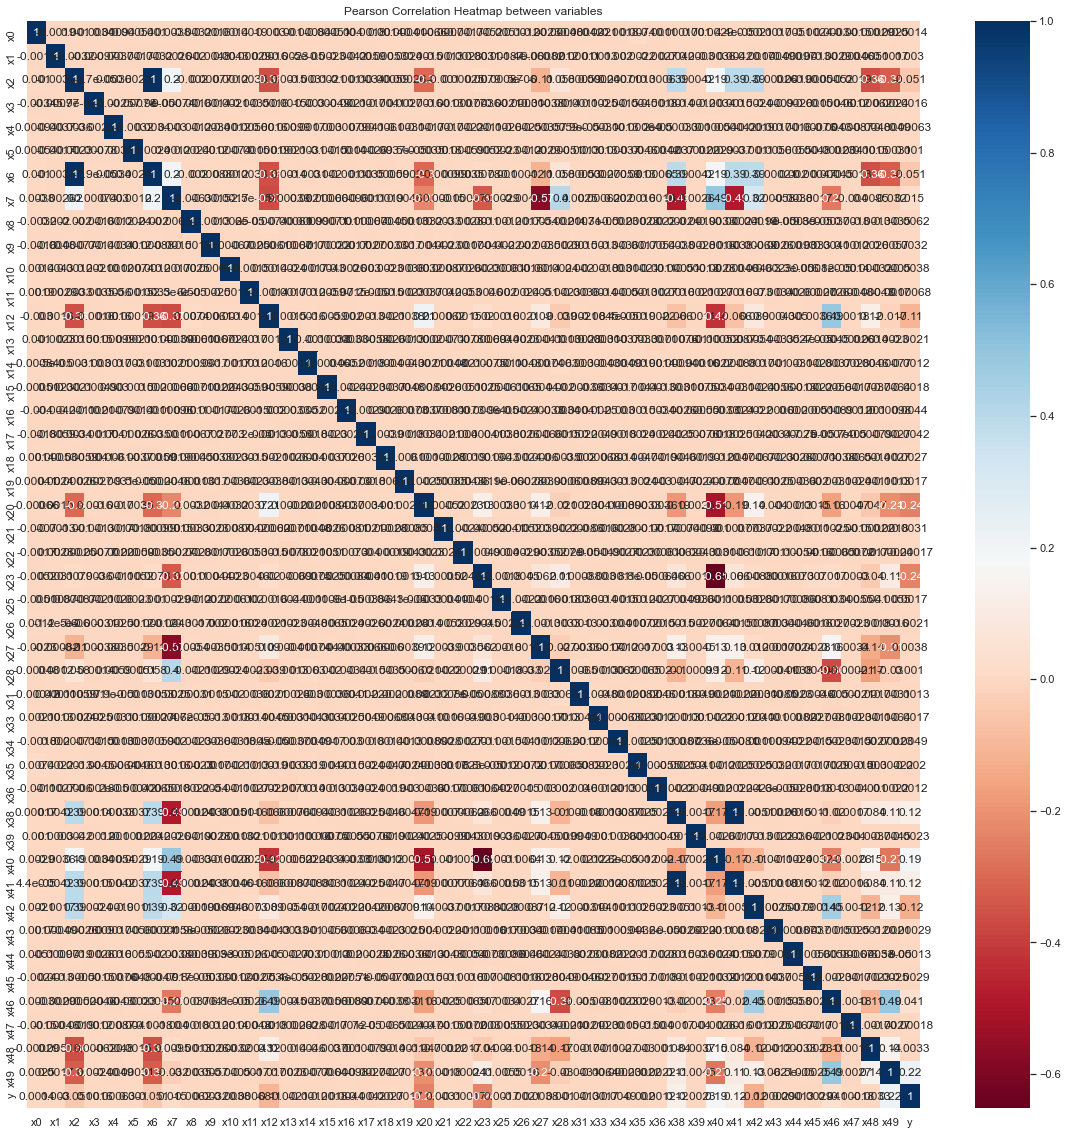

In [252]:
ax, fig = plt.subplots(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(df.corr(), annot=True, cmap = 'RdBu') 
plt.title("Pearson Correlation Heatmap between variables")
plt.show()